In [2]:
import numpy as np
import random

from sklearn.datasets import load_breast_cancer 
import numpy as np

# Load dataset
breast_cancer = load_breast_cancer()

# Extract the features

X= breast_cancer.data

print("Number of data objects: ", X.shape[0])
print("Number of features: ", X.shape[1])

Number of data objects:  569
Number of features:  30


In [14]:
print("Number of data objects: ", X.shape[0])
print("Number of features: ", X.shape[1])

Number of data objects:  569
Number of features:  30


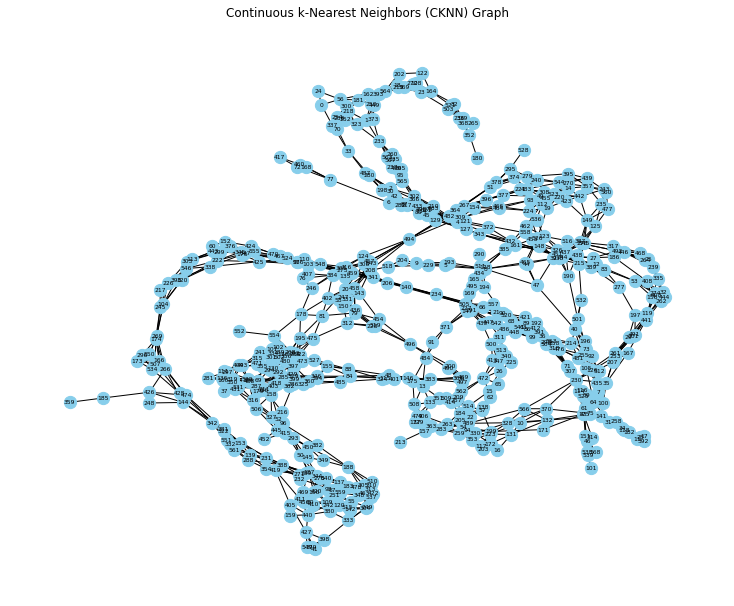

In [3]:
#FINAL GRAPH CODE: Compute the CkNN graph

import numpy as np
from sklearn.datasets import load_iris
from sklearn.neighbors import NearestNeighbors
import networkx as nx
import matplotlib.pyplot as plt

X

#First compute the kNN graph
def compute_cknn_graph(X, k, delta):
    nbrs = NearestNeighbors(n_neighbors=k+1, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)

    # Graph construction code
    G = nx.Graph()

  #Selecting the k center for the nearest neighbour
    for i in range(len(X)):
        center = X[i]
        neighbors = indices[i, 1:]
        #distances to the k nearest neighbour
        distances_to_center = distances[i, 1:]

        for neighbor, distance in zip(neighbors, distances_to_center):
            # Berry and Sauer's delta metric condition
            if distance < delta * np.sqrt(distances_to_center[-1] * distances[neighbor, -1]):
                #weight = np.exp(-(distance/delta)**2)  # Gaussian kernel weight
                G.add_edge(i, neighbor)

    return G

# Set parameters
k = 7
delta = 1

# Compute CKNN graph
cknn_graph = compute_cknn_graph(X, k, delta)

# Visualize the graph
pos = nx.spring_layout(cknn_graph, seed=42)  #  Set seed for the consistency of graph output
#pos = nx.spring_layout(cknn_graph)
edge_labels = nx.get_edge_attributes(cknn_graph, 'weight')

plt.figure(figsize=(10, 8))
nx.draw(cknn_graph, pos, with_labels=True, node_size=150, node_color='skyblue', font_size=6, font_color='black')
nx.draw_networkx_edge_labels(cknn_graph, pos, edge_labels=edge_labels, font_color='red', font_size=6)
plt.title('Continuous k-Nearest Neighbors (CKNN) Graph')
plt.show()

In [4]:
# Adjacency matrix
A = nx.adjacency_matrix(cknn_graph).todense()

# Degree matrix
D= np.diag([cknn_graph.degree(n) for n in cknn_graph.nodes()])

# Total number of edges
m= cknn_graph.number_of_edges()

print("Adjacency Matrix:")
print(A)
print("\nDegree Matrix:")
print(D)
print("\nTotal Number of Edges:")
print(m)

Adjacency Matrix:
[[0 1 1 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]

Degree Matrix:
[[3 0 0 ... 0 0 0]
 [0 6 0 ... 0 0 0]
 [0 0 6 ... 0 0 0]
 ...
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 1 0]
 [0 0 0 ... 0 0 1]]

Total Number of Edges:
1655


In [5]:
#Step 3: Compute the Matrix representation to model the markov process (random walk)

import numpy as np
from scipy.linalg import expm

#invert the Diagonal degree matrix D
Inverse_D = np.linalg.inv(D)
# Compute the random walk transition matrix M
M=Inverse_D @ A

# Compute the stationary distribution π
#diagonal values of the degree matrix
d = np.diag(D)
# sum total of the edges
m = np.sum(d)
#stationary distrubution denoted by π
pi = (d.T) / (2 * m)

#encoding of stationary distribution
prod=D/(2*m)

# Ensure prod is a 1-D array
prod = np.squeeze(np.asarray(prod))


In [32]:
from scipy.sparse import csr_matrix
from community import community_louvain
import numpy as np
import networkx as nx

# Compute the transition matrix P(t) for a range of t values
t_values = np.linspace(1250, 1300, 10)
P_values = [csr_matrix(np.squeeze(np.asarray(expm(-t * (np.eye(A.shape[0]) - M))))) for t in t_values]

# Run the Louvain algorithm at specific times
for t, P in zip(t_values, P_values):
    # Create a weighted graph from the transition matrix P at time t
    G = nx.from_numpy_array(P.toarray())

    # Compute the best partition using the Louvain method
    partition = community_louvain.best_partition(G)

    # Compute the Markov Stability
    r = 0
    for community in set(partition.values()):
        nodes_in_community = [node for node, comm in partition.items() if comm == community]
        P_submatrix = P[nodes_in_community][:, nodes_in_community].toarray()
        # Assume prod is a 2D array and nodes_in_community is a list of indices
        prod_submatrix = prod[nodes_in_community, nodes_in_community]
        #prod_submatrix = prod[nodes_in_community]
        B_submatrix_sum = np.sum(prod_submatrix[:, None] * P_submatrix) - np.sum(prod_submatrix)**2
        r += B_submatrix_sum

    # Count the number of partitions
    num_partitions = len(set(partition.values()))

    print(f"Time: {t}, Number of partitions: {num_partitions}, Markov Stability: {r}")

Time: 1250.0, Number of partitions: 2, Markov Stability: 0.24991715249231317
Time: 1255.5555555555557, Number of partitions: 2, Markov Stability: 0.24964840266737992
Time: 1261.111111111111, Number of partitions: 2, Markov Stability: 0.24938043651339414
Time: 1266.6666666666667, Number of partitions: 2, Markov Stability: 0.24911324926521355
Time: 1272.2222222222222, Number of partitions: 2, Markov Stability: 0.2488468362103904
Time: 1277.7777777777778, Number of partitions: 2, Markov Stability: 0.24858119268864382
Time: 1283.3333333333333, Number of partitions: 2, Markov Stability: 0.24831631409092436
Time: 1288.888888888889, Number of partitions: 2, Markov Stability: 0.24805219585883448
Time: 1294.4444444444443, Number of partitions: 2, Markov Stability: 0.24778883348388125
Time: 1300.0, Number of partitions: 2, Markov Stability: 0.24752622250689615


In [37]:
from scipy.sparse import csr_matrix
from community import community_louvain
from sklearn.metrics import mutual_info_score
import numpy as np
import networkx as nx

# Compute the transition matrix P(t) for a range of t values
t_values = np.linspace(1250, 1300, 10)
P_values = [csr_matrix(np.squeeze(np.asarray(expm(-t * (np.eye(A.shape[0]) - M))))) for t in t_values]

# Initialize the previous labels to None
prev_labels = None

# Run the Louvain algorithm at specific times
for t, P in zip(t_values, P_values):
    # Create a weighted graph from the transition matrix P at time t
    G = nx.from_numpy_array(P.toarray())

    # Compute the best partition using the Louvain method
    partition = community_louvain.best_partition(G)

    # Create a list of labels from the partition
    labels = [partition[node] for node in range(len(partition))]

    # Compute the Markov Stability
    r = 0
    for community in set(partition.values()):
        nodes_in_community = [node for node, comm in partition.items() if comm == community]
        P_submatrix = P[nodes_in_community][:, nodes_in_community].toarray()
        prod_submatrix = prod[nodes_in_community, nodes_in_community]
        B_submatrix_sum = np.sum(prod_submatrix[:, None] * P_submatrix) - np.sum(prod_submatrix)**2
        r += B_submatrix_sum

    # Count the number of partitions
    num_partitions = len(set(partition.values()))

    # Compute the Variation of Information if there are previous labels
    if prev_labels is not None:
        mutual_info = mutual_info_score(prev_labels, labels)
        entropy_prev = -np.sum([p * np.log(p) for p in np.bincount(prev_labels) / len(prev_labels)])
        entropy_curr = -np.sum([p * np.log(p) for p in np.bincount(labels) / len(labels)])
        vi = entropy_prev + entropy_curr - 2 * mutual_info
        print(f"Time: {t}, Number of partitions: {num_partitions}, Markov Stability: {r}, Variation of Information: {vi}")

    # Update the previous labels
    prev_labels = labels

Time: 1255.5555555555557, Number of partitions: 2, Markov Stability: 0.24964840266737992, Variation of Information: -6.661338147750939e-16
Time: 1261.111111111111, Number of partitions: 2, Markov Stability: 0.24938043651339414, Variation of Information: -6.661338147750939e-16
Time: 1266.6666666666667, Number of partitions: 2, Markov Stability: 0.24911324926521355, Variation of Information: -6.661338147750939e-16
Time: 1272.2222222222222, Number of partitions: 2, Markov Stability: 0.2488468362103904, Variation of Information: -6.661338147750939e-16
Time: 1277.7777777777778, Number of partitions: 2, Markov Stability: 0.24858119268864382, Variation of Information: -6.661338147750939e-16
Time: 1283.3333333333333, Number of partitions: 2, Markov Stability: 0.24831631409092436, Variation of Information: -6.661338147750939e-16
Time: 1288.888888888889, Number of partitions: 2, Markov Stability: 0.24805219585883448, Variation of Information: -6.661338147750939e-16
Time: 1294.4444444444443, Numb

In [38]:
from scipy.sparse import csr_matrix
from community import community_louvain
from sklearn.metrics import mutual_info_score
import numpy as np
import networkx as nx

# Set the Markov time
t = 1266

# Compute the transition matrix P(t)
P = csr_matrix(np.squeeze(np.asarray(expm(-t * (np.eye(A.shape[0]) - M)))))

# Create a weighted graph from the transition matrix P
G = nx.from_numpy_array(P.toarray())

# Run the algorithm 10 times
for i in range(10):
    # Compute the best partition using the Louvain method
    partition = community_louvain.best_partition(G)

    # Create a list of labels from the partition
    labels = [partition[node] for node in range(len(partition))]

    # Compute the Markov Stability
    r = 0
    for community in set(partition.values()):
        nodes_in_community = [node for node, comm in partition.items() if comm == community]
        P_submatrix = P[nodes_in_community][:, nodes_in_community].toarray()
        prod_submatrix = prod[nodes_in_community, nodes_in_community]
        B_submatrix_sum = np.sum(prod_submatrix[:, None] * P_submatrix) - np.sum(prod_submatrix)**2
        r += B_submatrix_sum

    # Count the number of partitions
    num_partitions = len(set(partition.values()))

    print(f"Run: {i+1}, Time: {t}, Number of partitions: {num_partitions}, Markov Stability: {r}")

Run: 1, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 2, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 3, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 4, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 5, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 6, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 7, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 8, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 9, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
Run: 10, Time: 1266, Number of partitions: 2, Markov Stability: 0.24914527076519183
